In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [11]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

In [4]:
class _3D_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        return {'images': data, 'label': label}

In [5]:
train_dataset_ = _3D_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = _3D_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = _3D_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
import torch
# from torchvision.models import resnet18
from monai.networks.nets import DenseNet121, resnet, resnet18
from acsconv.converters import ACSConverter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_2d is a standard pytorch 2D model
model_2d = resnet18(pretrained=False, spatial_dims=3, n_input_channels=1, num_classes=n_classes).to(device)
# model_2d = resnet18(pretrained=True)

model_3d = ACSConverter(model_2d).to(device)
# once converted, model_3d is using ACSConv and capable of processing 3D volumes.
# model_3d.fc = nn.Linear(model_3d.fc.in_features, n_classes)
# model_3d = model_3d.to(device)
print(model_3d)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3d.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()




ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model_3d.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model_3d(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model_3d.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model_3d(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model_3d.state_dict(), os.path.join(root_dir, "best_metric_model_ACS.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.60it/s, train_loss=1.09]
                                                                                  

epoch 1 average loss: 1.6469
1


Epochs:   1%|          | 1/100 [00:25<42:17, 25.63s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5883 current accuracy: 0.0932 best AUC: 0.5883 at epoch: 1
----------
epoch 2/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.696]
                                                                                   

epoch 2 average loss: 0.9873
1


Epochs:   2%|▏         | 2/100 [00:51<42:19, 25.91s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9709 current accuracy: 0.6273 best AUC: 0.9709 at epoch: 2
----------
epoch 3/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.812]
                                                                                   

epoch 3 average loss: 0.7132
1


Epochs:   3%|▎         | 3/100 [01:17<42:06, 26.04s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9724 current accuracy: 0.5714 best AUC: 0.9724 at epoch: 3
----------
epoch 4/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.736]
                                                                                   

epoch 4 average loss: 0.6509


Epochs:   4%|▍         | 4/100 [01:42<40:52, 25.55s/it]

1
current epoch: 4 current AUC: 0.8953 current accuracy: 0.3478 best AUC: 0.9724 at epoch: 3
----------
epoch 5/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.456]
                                                                                   

epoch 5 average loss: 0.6055
1


Epochs:   5%|▌         | 5/100 [02:09<40:52, 25.82s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9826 current accuracy: 0.7143 best AUC: 0.9826 at epoch: 5
----------
epoch 6/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.424]
                                                                                   

epoch 6 average loss: 0.4965
1


Epochs:   6%|▌         | 6/100 [02:35<40:36, 25.92s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9853 current accuracy: 0.7267 best AUC: 0.9853 at epoch: 6
----------
epoch 7/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.551]
                                                                                   

epoch 7 average loss: 0.4540
1


Epochs:   7%|▋         | 7/100 [03:01<40:21, 26.04s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9890 at epoch: 7
----------
epoch 8/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.73]
                                                                                  

epoch 8 average loss: 0.4388


Epochs:   8%|▊         | 8/100 [03:26<39:23, 25.69s/it]

1
current epoch: 8 current AUC: 0.9877 current accuracy: 0.8323 best AUC: 0.9890 at epoch: 7
----------
epoch 9/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.883]
                                                                                   

epoch 9 average loss: 0.4118


Epochs:   9%|▉         | 9/100 [03:51<38:47, 25.57s/it]

1
current epoch: 9 current AUC: 0.9874 current accuracy: 0.7019 best AUC: 0.9890 at epoch: 7
----------
epoch 10/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.407]
                                                                                   

epoch 10 average loss: 0.3969


Epochs:  10%|█         | 10/100 [04:16<38:04, 25.38s/it]

1
current epoch: 10 current AUC: 0.9828 current accuracy: 0.7950 best AUC: 0.9890 at epoch: 7
----------
epoch 11/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.54it/s, train_loss=0.319]
                                                                                   

epoch 11 average loss: 0.3179


Epochs:  11%|█         | 11/100 [04:41<37:14, 25.10s/it]

1
current epoch: 11 current AUC: 0.9874 current accuracy: 0.8447 best AUC: 0.9890 at epoch: 7
----------
epoch 12/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.546]
                                                                                   

epoch 12 average loss: 0.3336


Epochs:  12%|█▏        | 12/100 [05:06<36:49, 25.11s/it]

1
current epoch: 12 current AUC: 0.9887 current accuracy: 0.8571 best AUC: 0.9890 at epoch: 7
----------
epoch 13/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.61it/s, train_loss=0.394]
                                                                                   

epoch 13 average loss: 0.3127


Epochs:  13%|█▎        | 13/100 [05:30<36:14, 25.00s/it]

1
current epoch: 13 current AUC: 0.9809 current accuracy: 0.7888 best AUC: 0.9890 at epoch: 7
----------
epoch 14/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0957]
                                                                                    

epoch 14 average loss: 0.2725
1


Epochs:  14%|█▍        | 14/100 [05:57<36:22, 25.38s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9941 current accuracy: 0.7950 best AUC: 0.9941 at epoch: 14
----------
epoch 15/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.505]
                                                                                   

epoch 15 average loss: 0.2804


Epochs:  15%|█▌        | 15/100 [06:22<35:45, 25.24s/it]

1
current epoch: 15 current AUC: 0.9912 current accuracy: 0.7640 best AUC: 0.9941 at epoch: 14
----------
epoch 16/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.198]
                                                                                   

epoch 16 average loss: 0.2587


Epochs:  16%|█▌        | 16/100 [06:46<35:08, 25.10s/it]

1
current epoch: 16 current AUC: 0.9855 current accuracy: 0.7081 best AUC: 0.9941 at epoch: 14
----------
epoch 17/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.222]
                                                                                   

epoch 17 average loss: 0.2350
1


Epochs:  17%|█▋        | 17/100 [07:13<35:08, 25.40s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9981 current accuracy: 0.9193 best AUC: 0.9981 at epoch: 17
----------
epoch 18/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.162]
                                                                                   

epoch 18 average loss: 0.2302


Epochs:  18%|█▊        | 18/100 [07:37<34:31, 25.27s/it]

1
current epoch: 18 current AUC: 0.9922 current accuracy: 0.8261 best AUC: 0.9981 at epoch: 17
----------
epoch 19/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.437]
                                                                                   

epoch 19 average loss: 0.2403


Epochs:  19%|█▉        | 19/100 [08:02<33:51, 25.09s/it]

1
current epoch: 19 current AUC: 0.9914 current accuracy: 0.8634 best AUC: 0.9981 at epoch: 17
----------
epoch 20/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.195]
                                                                                   

epoch 20 average loss: 0.2128


Epochs:  20%|██        | 20/100 [08:27<33:19, 24.99s/it]

1
current epoch: 20 current AUC: 0.9963 current accuracy: 0.9193 best AUC: 0.9981 at epoch: 17
----------
epoch 21/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.42]
                                                                                  

epoch 21 average loss: 0.2117


Epochs:  21%|██        | 21/100 [08:52<32:51, 24.95s/it]

1
current epoch: 21 current AUC: 0.9830 current accuracy: 0.7081 best AUC: 0.9981 at epoch: 17
----------
epoch 22/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.162]
                                                                                   

epoch 22 average loss: 0.2260


Epochs:  22%|██▏       | 22/100 [09:17<32:27, 24.97s/it]

1
current epoch: 22 current AUC: 0.9926 current accuracy: 0.8199 best AUC: 0.9981 at epoch: 17
----------
epoch 23/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.173]
                                                                                   

epoch 23 average loss: 0.1937


Epochs:  23%|██▎       | 23/100 [09:41<31:55, 24.87s/it]

1
current epoch: 23 current AUC: 0.9971 current accuracy: 0.8323 best AUC: 0.9981 at epoch: 17
----------
epoch 24/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.108]
                                                                                   

epoch 24 average loss: 0.1844


Epochs:  24%|██▍       | 24/100 [10:06<31:32, 24.90s/it]

1
current epoch: 24 current AUC: 0.9893 current accuracy: 0.8509 best AUC: 0.9981 at epoch: 17
----------
epoch 25/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=0.2]
                                                                                 

epoch 25 average loss: 0.1955


Epochs:  25%|██▌       | 25/100 [10:31<30:54, 24.73s/it]

1
current epoch: 25 current AUC: 0.9764 current accuracy: 0.7391 best AUC: 0.9981 at epoch: 17
----------
epoch 26/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.165]
                                                                                   

epoch 26 average loss: 0.1626


Epochs:  26%|██▌       | 26/100 [10:56<30:31, 24.75s/it]

1
current epoch: 26 current AUC: 0.9925 current accuracy: 0.7950 best AUC: 0.9981 at epoch: 17
----------
epoch 27/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.334]
                                                                                   

epoch 27 average loss: 0.1571


Epochs:  27%|██▋       | 27/100 [11:21<30:11, 24.82s/it]

1
current epoch: 27 current AUC: 0.9930 current accuracy: 0.9193 best AUC: 0.9981 at epoch: 17
----------
epoch 28/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0997]
                                                                                    

epoch 28 average loss: 0.1695


Epochs:  28%|██▊       | 28/100 [11:45<29:47, 24.82s/it]

1
current epoch: 28 current AUC: 0.9874 current accuracy: 0.8571 best AUC: 0.9981 at epoch: 17
----------
epoch 29/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.315]
                                                                                   

epoch 29 average loss: 0.1428


Epochs:  29%|██▉       | 29/100 [12:10<29:24, 24.85s/it]

1
current epoch: 29 current AUC: 0.9789 current accuracy: 0.8509 best AUC: 0.9981 at epoch: 17
----------
epoch 30/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.141]
                                                                                   

epoch 30 average loss: 0.1191


Epochs:  30%|███       | 30/100 [12:35<28:59, 24.85s/it]

1
current epoch: 30 current AUC: 0.9954 current accuracy: 0.9255 best AUC: 0.9981 at epoch: 17
----------
epoch 31/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.261]
                                                                                   

epoch 31 average loss: 0.1249


Epochs:  31%|███       | 31/100 [13:00<28:35, 24.87s/it]

1
current epoch: 31 current AUC: 0.9961 current accuracy: 0.8820 best AUC: 0.9981 at epoch: 17
----------
epoch 32/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.204]
                                                                                   

epoch 32 average loss: 0.1204


Epochs:  32%|███▏      | 32/100 [13:25<28:09, 24.84s/it]

1
current epoch: 32 current AUC: 0.9903 current accuracy: 0.8261 best AUC: 0.9981 at epoch: 17
----------
epoch 33/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.29]
                                                                                  

epoch 33 average loss: 0.1134


Epochs:  33%|███▎      | 33/100 [13:50<27:48, 24.90s/it]

1
current epoch: 33 current AUC: 0.9953 current accuracy: 0.8509 best AUC: 0.9981 at epoch: 17
----------
epoch 34/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.143]
                                                                                   

epoch 34 average loss: 0.1094
1


Epochs:  34%|███▍      | 34/100 [14:16<27:47, 25.26s/it]

saved new best metric model
current epoch: 34 current AUC: 0.9983 current accuracy: 0.9441 best AUC: 0.9983 at epoch: 34
----------
epoch 35/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0917]
                                                                                    

epoch 35 average loss: 0.1105


Epochs:  35%|███▌      | 35/100 [14:41<27:14, 25.14s/it]

1
current epoch: 35 current AUC: 0.9928 current accuracy: 0.8820 best AUC: 0.9983 at epoch: 34
----------
epoch 36/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.57it/s, train_loss=0.0446]
                                                                                    

epoch 36 average loss: 0.1434


Epochs:  36%|███▌      | 36/100 [15:05<26:38, 24.98s/it]

1
current epoch: 36 current AUC: 0.9948 current accuracy: 0.9068 best AUC: 0.9983 at epoch: 34
----------
epoch 37/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0826]
                                                                                    

epoch 37 average loss: 0.1007


Epochs:  37%|███▋      | 37/100 [15:30<26:10, 24.93s/it]

1
current epoch: 37 current AUC: 0.9934 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 34
----------
epoch 38/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.109]
                                                                                   

epoch 38 average loss: 0.0896


Epochs:  38%|███▊      | 38/100 [15:55<25:46, 24.94s/it]

1
current epoch: 38 current AUC: 0.9937 current accuracy: 0.9006 best AUC: 0.9983 at epoch: 34
----------
epoch 39/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.335]
                                                                                   

epoch 39 average loss: 0.0986


Epochs:  39%|███▉      | 39/100 [16:20<25:21, 24.95s/it]

1
current epoch: 39 current AUC: 0.9970 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 34
----------
epoch 40/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.102]
                                                                                   

epoch 40 average loss: 0.0847


Epochs:  40%|████      | 40/100 [16:45<25:00, 25.00s/it]

1
current epoch: 40 current AUC: 0.9926 current accuracy: 0.8509 best AUC: 0.9983 at epoch: 34
----------
epoch 41/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0825]
                                                                                    

epoch 41 average loss: 0.0634


Epochs:  41%|████      | 41/100 [17:10<24:35, 25.01s/it]

1
current epoch: 41 current AUC: 0.9894 current accuracy: 0.8137 best AUC: 0.9983 at epoch: 34
----------
epoch 42/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.101]
                                                                                   

epoch 42 average loss: 0.0496


Epochs:  42%|████▏     | 42/100 [17:35<24:11, 25.02s/it]

1
current epoch: 42 current AUC: 0.9950 current accuracy: 0.9006 best AUC: 0.9983 at epoch: 34
----------
epoch 43/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.11]
                                                                                  

epoch 43 average loss: 0.0789


Epochs:  43%|████▎     | 43/100 [18:00<23:44, 25.00s/it]

1
current epoch: 43 current AUC: 0.9975 current accuracy: 0.9441 best AUC: 0.9983 at epoch: 34
----------
epoch 44/100



Training Batches: 100%|██████████| 31/31 [00:23<00:00,  1.55it/s, train_loss=0.251]
                                                                                   

epoch 44 average loss: 0.0776


Epochs:  44%|████▍     | 44/100 [18:25<23:13, 24.88s/it]

1
current epoch: 44 current AUC: 0.9822 current accuracy: 0.8447 best AUC: 0.9983 at epoch: 34
----------
epoch 45/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.113]
                                                                                   

epoch 45 average loss: 0.1212


Epochs:  45%|████▌     | 45/100 [18:50<22:49, 24.89s/it]

1
current epoch: 45 current AUC: 0.9696 current accuracy: 0.6149 best AUC: 0.9983 at epoch: 34
----------
epoch 46/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0267]
                                                                                    

epoch 46 average loss: 0.0764


Epochs:  46%|████▌     | 46/100 [19:15<22:24, 24.89s/it]

1
current epoch: 46 current AUC: 0.9941 current accuracy: 0.9255 best AUC: 0.9983 at epoch: 34
----------
epoch 47/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.0306]
                                                                                    

epoch 47 average loss: 0.0633


Epochs:  47%|████▋     | 47/100 [19:40<21:58, 24.88s/it]

1
current epoch: 47 current AUC: 0.9962 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 34
----------
epoch 48/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.189]
                                                                                   

epoch 48 average loss: 0.0695


Epochs:  48%|████▊     | 48/100 [20:04<21:31, 24.84s/it]

1
current epoch: 48 current AUC: 0.9863 current accuracy: 0.8385 best AUC: 0.9983 at epoch: 34
----------
epoch 49/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0473]
                                                                                    

epoch 49 average loss: 0.0683


Epochs:  49%|████▉     | 49/100 [20:29<21:08, 24.87s/it]

1
current epoch: 49 current AUC: 0.9852 current accuracy: 0.8758 best AUC: 0.9983 at epoch: 34
----------
epoch 50/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0269]
                                                                                    

epoch 50 average loss: 0.0651


Epochs:  50%|█████     | 50/100 [20:54<20:41, 24.83s/it]

1
current epoch: 50 current AUC: 0.9942 current accuracy: 0.9193 best AUC: 0.9983 at epoch: 34
----------
epoch 51/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0371]
                                                                                    

epoch 51 average loss: 0.0363


Epochs:  51%|█████     | 51/100 [21:19<20:18, 24.86s/it]

1
current epoch: 51 current AUC: 0.9937 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 34
----------
epoch 52/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.0712]
                                                                                    

epoch 52 average loss: 0.0350


Epochs:  52%|█████▏    | 52/100 [21:44<19:58, 24.96s/it]

1
current epoch: 52 current AUC: 0.9957 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 34
----------
epoch 53/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0268]
                                                                                    

epoch 53 average loss: 0.0480


Epochs:  53%|█████▎    | 53/100 [22:09<19:35, 25.00s/it]

1
current epoch: 53 current AUC: 0.9952 current accuracy: 0.9317 best AUC: 0.9983 at epoch: 34
----------
epoch 54/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.19]
                                                                                  

epoch 54 average loss: 0.0429


Epochs:  54%|█████▍    | 54/100 [22:34<19:10, 25.00s/it]

1
current epoch: 54 current AUC: 0.9935 current accuracy: 0.8882 best AUC: 0.9983 at epoch: 34
----------
epoch 55/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.407]
                                                                                   

epoch 55 average loss: 0.0735


Epochs:  55%|█████▌    | 55/100 [22:59<18:43, 24.96s/it]

1
current epoch: 55 current AUC: 0.9944 current accuracy: 0.9068 best AUC: 0.9983 at epoch: 34
----------
epoch 56/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.022]
                                                                                   

epoch 56 average loss: 0.0745


Epochs:  56%|█████▌    | 56/100 [23:24<18:18, 24.96s/it]

1
current epoch: 56 current AUC: 0.9929 current accuracy: 0.8820 best AUC: 0.9983 at epoch: 34
----------
epoch 57/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.147]
                                                                                   

epoch 57 average loss: 0.0467


Epochs:  57%|█████▋    | 57/100 [23:49<17:53, 24.96s/it]

1
current epoch: 57 current AUC: 0.9973 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 34
----------
epoch 58/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.261]
                                                                                   

epoch 58 average loss: 0.0813


Epochs:  58%|█████▊    | 58/100 [24:14<17:29, 24.99s/it]

1
current epoch: 58 current AUC: 0.9944 current accuracy: 0.9193 best AUC: 0.9983 at epoch: 34
----------
epoch 59/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.0113]
                                                                                    

epoch 59 average loss: 0.0763


Epochs:  59%|█████▉    | 59/100 [24:39<17:05, 25.01s/it]

1
current epoch: 59 current AUC: 0.9925 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 34
----------
epoch 60/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.50it/s, train_loss=0.0617]
                                                                                    

epoch 60 average loss: 0.0493


Epochs:  60%|██████    | 60/100 [25:04<16:39, 24.98s/it]

1
current epoch: 60 current AUC: 0.9947 current accuracy: 0.8820 best AUC: 0.9983 at epoch: 34
----------
epoch 61/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.50it/s, train_loss=0.0225]
                                                                                    

epoch 61 average loss: 0.0553


Epochs:  61%|██████    | 61/100 [25:29<16:16, 25.04s/it]

1
current epoch: 61 current AUC: 0.9906 current accuracy: 0.8696 best AUC: 0.9983 at epoch: 34
----------
epoch 62/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.262]
                                                                                   

epoch 62 average loss: 0.0546


Epochs:  62%|██████▏   | 62/100 [25:54<15:52, 25.06s/it]

1
current epoch: 62 current AUC: 0.9918 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 34
----------
epoch 63/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.0632]
                                                                                    

epoch 63 average loss: 0.0368


Epochs:  63%|██████▎   | 63/100 [26:19<15:26, 25.03s/it]

1
current epoch: 63 current AUC: 0.9876 current accuracy: 0.8634 best AUC: 0.9983 at epoch: 34
----------
epoch 64/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.101]
                                                                                   

epoch 64 average loss: 0.0321


Epochs:  64%|██████▍   | 64/100 [26:44<14:59, 25.00s/it]

1
current epoch: 64 current AUC: 0.9937 current accuracy: 0.9255 best AUC: 0.9983 at epoch: 34
----------
epoch 65/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0104]
                                                                                    

epoch 65 average loss: 0.0364


Epochs:  65%|██████▌   | 65/100 [27:09<14:34, 24.99s/it]

1
current epoch: 65 current AUC: 0.9950 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 34
----------
epoch 66/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0731]
                                                                                    

epoch 66 average loss: 0.0332


Epochs:  66%|██████▌   | 66/100 [27:34<14:08, 24.95s/it]

1
current epoch: 66 current AUC: 0.9929 current accuracy: 0.8820 best AUC: 0.9983 at epoch: 34
----------
epoch 67/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.0452]
                                                                                    

epoch 67 average loss: 0.0452


Epochs:  67%|██████▋   | 67/100 [27:59<13:42, 24.91s/it]

1
current epoch: 67 current AUC: 0.9964 current accuracy: 0.9317 best AUC: 0.9983 at epoch: 34
----------
epoch 68/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0507]
                                                                                    

epoch 68 average loss: 0.0315


Epochs:  68%|██████▊   | 68/100 [28:24<13:20, 25.01s/it]

1
current epoch: 68 current AUC: 0.9960 current accuracy: 0.9317 best AUC: 0.9983 at epoch: 34
----------
epoch 69/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.0874]
                                                                                    

epoch 69 average loss: 0.0199
1


Epochs:  69%|██████▉   | 69/100 [28:50<13:05, 25.35s/it]

saved new best metric model
current epoch: 69 current AUC: 0.9989 current accuracy: 0.9565 best AUC: 0.9989 at epoch: 69
----------
epoch 70/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.00378]
                                                                                     

epoch 70 average loss: 0.0275


Epochs:  70%|███████   | 70/100 [29:15<12:38, 25.28s/it]

1
current epoch: 70 current AUC: 0.9882 current accuracy: 0.8944 best AUC: 0.9989 at epoch: 69
----------
epoch 71/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0135]
                                                                                    

epoch 71 average loss: 0.0277


Epochs:  71%|███████   | 71/100 [29:40<12:09, 25.17s/it]

1
current epoch: 71 current AUC: 0.9948 current accuracy: 0.8944 best AUC: 0.9989 at epoch: 69
----------
epoch 72/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.00844]
                                                                                     

epoch 72 average loss: 0.0232


Epochs:  72%|███████▏  | 72/100 [30:05<11:42, 25.10s/it]

1
current epoch: 72 current AUC: 0.9976 current accuracy: 0.9379 best AUC: 0.9989 at epoch: 69
----------
epoch 73/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.0814]
                                                                                    

epoch 73 average loss: 0.0372


Epochs:  73%|███████▎  | 73/100 [30:30<11:15, 25.03s/it]

1
current epoch: 73 current AUC: 0.9973 current accuracy: 0.9317 best AUC: 0.9989 at epoch: 69
----------
epoch 74/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.017]
                                                                                   

epoch 74 average loss: 0.0348


Epochs:  74%|███████▍  | 74/100 [30:55<10:51, 25.04s/it]

1
current epoch: 74 current AUC: 0.9962 current accuracy: 0.9441 best AUC: 0.9989 at epoch: 69
----------
epoch 75/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.135]
                                                                                   

epoch 75 average loss: 0.0501


Epochs:  75%|███████▌  | 75/100 [31:20<10:26, 25.06s/it]

1
current epoch: 75 current AUC: 0.9892 current accuracy: 0.7950 best AUC: 0.9989 at epoch: 69
----------
epoch 76/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0717]
                                                                                    

epoch 76 average loss: 0.0710


Epochs:  76%|███████▌  | 76/100 [31:45<10:00, 25.01s/it]

1
current epoch: 76 current AUC: 0.9966 current accuracy: 0.8944 best AUC: 0.9989 at epoch: 69
----------
epoch 77/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.49it/s, train_loss=0.0799]
                                                                                    

epoch 77 average loss: 0.0573


Epochs:  77%|███████▋  | 77/100 [32:10<09:36, 25.06s/it]

1
current epoch: 77 current AUC: 0.9945 current accuracy: 0.9255 best AUC: 0.9989 at epoch: 69
----------
epoch 78/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.369]
                                                                                   

epoch 78 average loss: 0.0344


Epochs:  78%|███████▊  | 78/100 [32:35<09:09, 24.97s/it]

1
current epoch: 78 current AUC: 0.9963 current accuracy: 0.9317 best AUC: 0.9989 at epoch: 69
----------
epoch 79/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.0298]
                                                                                    

epoch 79 average loss: 0.0546


Epochs:  79%|███████▉  | 79/100 [33:00<08:42, 24.90s/it]

1
current epoch: 79 current AUC: 0.9946 current accuracy: 0.8571 best AUC: 0.9989 at epoch: 69
----------
epoch 80/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0113]
                                                                                    

epoch 80 average loss: 0.0216


Epochs:  80%|████████  | 80/100 [33:25<08:18, 24.94s/it]

1
current epoch: 80 current AUC: 0.9961 current accuracy: 0.9441 best AUC: 0.9989 at epoch: 69
----------
epoch 81/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.0508]
                                                                                    

epoch 81 average loss: 0.0527


Epochs:  81%|████████  | 81/100 [33:50<07:54, 24.98s/it]

1
current epoch: 81 current AUC: 0.9883 current accuracy: 0.8199 best AUC: 0.9989 at epoch: 69
----------
epoch 82/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0171]
                                                                                    

epoch 82 average loss: 0.0392


Epochs:  82%|████████▏ | 82/100 [34:15<07:30, 25.02s/it]

1
current epoch: 82 current AUC: 0.9973 current accuracy: 0.9379 best AUC: 0.9989 at epoch: 69
----------
epoch 83/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.034]
                                                                                   

epoch 83 average loss: 0.0174


Epochs:  83%|████████▎ | 83/100 [34:40<07:03, 24.93s/it]

1
current epoch: 83 current AUC: 0.9963 current accuracy: 0.9317 best AUC: 0.9989 at epoch: 69
----------
epoch 84/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.476]
                                                                                   

epoch 84 average loss: 0.0497
1


Epochs:  84%|████████▍ | 84/100 [35:06<06:45, 25.31s/it]

saved new best metric model
current epoch: 84 current AUC: 0.9993 current accuracy: 0.9441 best AUC: 0.9993 at epoch: 84
----------
epoch 85/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0101]
                                                                                    

epoch 85 average loss: 0.0913


Epochs:  85%|████████▌ | 85/100 [35:31<06:17, 25.16s/it]

1
current epoch: 85 current AUC: 0.9893 current accuracy: 0.8820 best AUC: 0.9993 at epoch: 84
----------
epoch 86/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.0294]
                                                                                    

epoch 86 average loss: 0.0647


Epochs:  86%|████████▌ | 86/100 [35:56<05:51, 25.11s/it]

1
current epoch: 86 current AUC: 0.9937 current accuracy: 0.9255 best AUC: 0.9993 at epoch: 84
----------
epoch 87/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.126]
                                                                                   

epoch 87 average loss: 0.0317


Epochs:  87%|████████▋ | 87/100 [36:21<05:26, 25.10s/it]

1
current epoch: 87 current AUC: 0.9955 current accuracy: 0.9255 best AUC: 0.9993 at epoch: 84
----------
epoch 88/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.0097]
                                                                                    

epoch 88 average loss: 0.0236


Epochs:  88%|████████▊ | 88/100 [36:46<05:00, 25.06s/it]

1
current epoch: 88 current AUC: 0.9963 current accuracy: 0.9317 best AUC: 0.9993 at epoch: 84
----------
epoch 89/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.0831]
                                                                                    

epoch 89 average loss: 0.0270


Epochs:  89%|████████▉ | 89/100 [37:11<04:35, 25.02s/it]

1
current epoch: 89 current AUC: 0.9933 current accuracy: 0.9193 best AUC: 0.9993 at epoch: 84
----------
epoch 90/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.00977]
                                                                                     

epoch 90 average loss: 0.0217


Epochs:  90%|█████████ | 90/100 [37:36<04:10, 25.02s/it]

1
current epoch: 90 current AUC: 0.9934 current accuracy: 0.9068 best AUC: 0.9993 at epoch: 84
----------
epoch 91/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.112]
                                                                                   

epoch 91 average loss: 0.0302


Epochs:  91%|█████████ | 91/100 [38:01<03:45, 25.00s/it]

1
current epoch: 91 current AUC: 0.9922 current accuracy: 0.9006 best AUC: 0.9993 at epoch: 84
----------
epoch 92/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.372]
                                                                                   

epoch 92 average loss: 0.0490


Epochs:  92%|█████████▏| 92/100 [38:26<03:20, 25.06s/it]

1
current epoch: 92 current AUC: 0.9955 current accuracy: 0.9441 best AUC: 0.9993 at epoch: 84
----------
epoch 93/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.0459]
                                                                                    

epoch 93 average loss: 0.0491


Epochs:  93%|█████████▎| 93/100 [38:51<02:54, 24.96s/it]

1
current epoch: 93 current AUC: 0.9968 current accuracy: 0.9379 best AUC: 0.9993 at epoch: 84
----------
epoch 94/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.0242]
                                                                                    

epoch 94 average loss: 0.0387


Epochs:  94%|█████████▍| 94/100 [39:15<02:29, 24.92s/it]

1
current epoch: 94 current AUC: 0.9916 current accuracy: 0.8447 best AUC: 0.9993 at epoch: 84
----------
epoch 95/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.258]
                                                                                   

epoch 95 average loss: 0.0354


Epochs:  95%|█████████▌| 95/100 [39:40<02:04, 24.93s/it]

1
current epoch: 95 current AUC: 0.9951 current accuracy: 0.9068 best AUC: 0.9993 at epoch: 84
----------
epoch 96/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.207]
                                                                                   

epoch 96 average loss: 0.0397


Epochs:  96%|█████████▌| 96/100 [40:06<01:39, 24.99s/it]

1
current epoch: 96 current AUC: 0.9962 current accuracy: 0.9068 best AUC: 0.9993 at epoch: 84
----------
epoch 97/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.00624]
                                                                                     

epoch 97 average loss: 0.0500


Epochs:  97%|█████████▋| 97/100 [40:30<01:14, 24.95s/it]

1
current epoch: 97 current AUC: 0.9970 current accuracy: 0.9193 best AUC: 0.9993 at epoch: 84
----------
epoch 98/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.0375]
                                                                                    

epoch 98 average loss: 0.0342


Epochs:  98%|█████████▊| 98/100 [40:55<00:49, 24.94s/it]

1
current epoch: 98 current AUC: 0.9976 current accuracy: 0.9317 best AUC: 0.9993 at epoch: 84
----------
epoch 99/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.00449]
                                                                                     

epoch 99 average loss: 0.0183


Epochs:  99%|█████████▉| 99/100 [41:20<00:24, 24.96s/it]

1
current epoch: 99 current AUC: 0.9973 current accuracy: 0.9379 best AUC: 0.9993 at epoch: 84
----------
epoch 100/100



Training Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.0801]
                                                                                    

epoch 100 average loss: 0.0338


Epochs: 100%|██████████| 100/100 [41:46<00:00, 25.06s/it]

1
current epoch: 100 current AUC: 0.9978 current accuracy: 0.9006 best AUC: 0.9993 at epoch: 84
train completed, best_metric: 0.9993 at epoch: 84


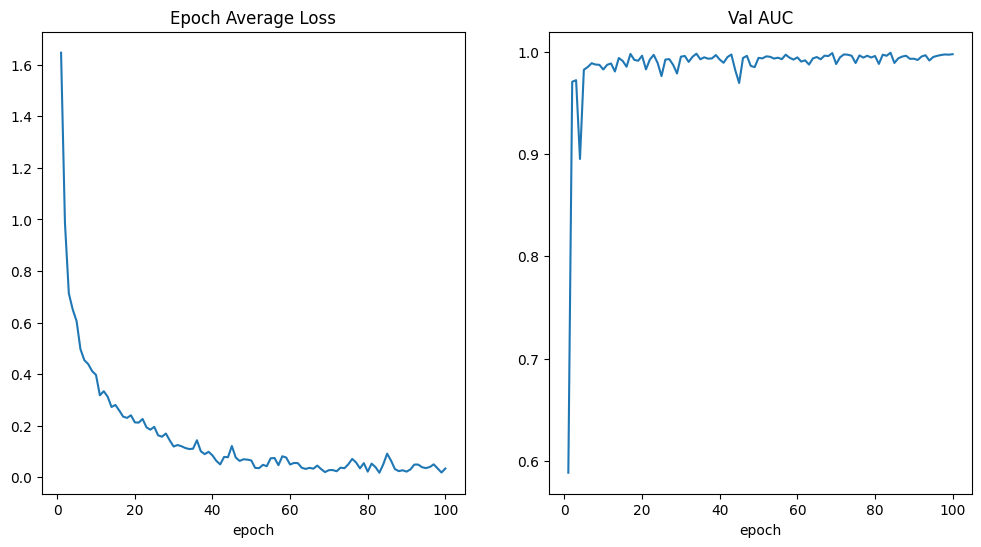

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [17]:
model_3d.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_ACS.pth"), weights_only=True))
model_3d.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model_3d(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [18]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.5773    0.8235    0.6788        68
           2     0.6667    0.5217    0.5854        69
           3     0.5775    0.6308    0.6029        65
           4     0.6333    0.5846    0.6080        65
           5     0.9839    0.9242    0.9531        66
           6     1.0000    1.0000    1.0000        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9836    0.8696    0.9231        69
          10     0.9697    0.9275    0.9481        69

    accuracy                         0.8115       610
   macro avg     0.8538    0.8438    0.8454       610
weighted avg     0.8241    0.8115    0.8136       610

